# 1. Motivations
This notebook accompanies my study of John Hull's *Options, futures and other derivatives*. The aim is to :  

- reinforce my own understanding of key concepts by implementing them in python
- build a reference I (and others) can revisit for intuition and interview preparation

While the organization broadly follows Hull's book, I add numerical illustrations and simulations whenever I feel a topic would benefit from a hands-on approach, but also maths/physics paragraph when I judge it necessary.

This is also a way for me to practice financial english terminology (I am French/Canadian), so you may occasionally come accross slight quirks in notation or language (don't hesitate to alert me if that's the case).

**Author:** Antonin Fournera  
**Contact:** fourneraa@gmail.com

# 2. Chap 5 : arround futures pricing
This section draws on material from chapter 1, 2 and 5. The objectives are to:
- analyze the impact of different OIS (risk-free) rates on no arbitrage futures prices
- illustrate the cost-of-carry relationship: $F_0 = S_0 e^{(r + u - y)T}$ $-$ we'll study $F_0 = S_0 e^{(r - q)T}$ for continously yield investment assets
- compare futures and forwards (especially MTM vs forward payoff)
- demonstrate how futures can be used to hedge spot
exposure.

## Modules

In [9]:
import numpy as np
import matplotlib.pyplot as plt

## Core code


### Functions
The point of this section is to implement functions that will be mandatory for the rest of the simulation. Note that we are doing a Monte-Carlo simulation of the market.

#### Reminder on GBM
GBM stands for geometric bronian motion. At this point in the book there is no mention of it, but it is 100% necessary so I'll explain it now.  
We're studying a Stochastic Differential Equation (SDE in the following) that discribe the continuous-time evolution of the asset price $S_t$ :  

$\frac{\mathrm{d}S_t}{\mathrm{d}t} - \mu S_t = \sigma S_t \frac{\mathrm{d}W_t}{\mathrm{d}t} \quad \textit{i.e.} \quad \frac{\mathrm{d}S_t}{S_t} = \mu \mathrm{d}t + \sigma \mathrm{d}W_t$  

where :  
- $\frac{\mathrm{d}S_t}{S_t}$ is the instantaneous rate of return
- $\mu$ is the drift term, representing the deterministic, non random part of the equation
- $\mathrm{d}W_t$ is the Wienner Increment (or BM increment), representing the random part. We have $\mathrm{d}W_t \sim \mathrm{N}(0, \mathrm{d}t)$
- $\sigma$ is the volatility term, which scales the randomness   

We solve this equation via Itô's lemma (chapter 16, see later) and we get :  
$\mathrm{d}(ln(S_t)) = (\mu - 1/2 \sigma^2)\mathrm{d}t + \sigma \mathrm{d}W_t$  
This shows that $ln(S_t)$ follows a Standard BM with drif $\mu - 1/2 \sigma^2$ and volatility $\sigma$

In discrete terms for computation, we substitute the infinitelly small $\mathrm{d}$ for a $\Delta$. Knowing that $\Delta W_t$ is modeled as a normal variable, we get :  
$\Delta W_t = \sqrt{\Delta t} Z$ where $\mathrm{Z} \sim \mathrm{N}(0, 1)$

Thus, we need to implement : $ln(S_{t + \Delta t}) - ln(S_t) = (\mu - 1/2 \sigma^2)\Delta t + \sigma \sqrt{\Delta t} . Z$
By taking the cumulative sum of these $\Delta (ln(S_t))$ and then applying the $exp$ we get : 

|   $S_t = S_0 . exp((\mu - 1/2 \sigma^2)t + \sigma W_t)$   |
|:---:|

In [10]:

def th_futures_price(S, T, r, q):
    """
    We use the continuous cost-of-cary formula :
        f = S*exp((r - q)*T) where :
    S: current spot
    r: continuously compound risk-free rate
    q: continuous dividend yield (or storage cost as negative)
    T: time to maturity
    """
    return(S*np.exp((r - q)*T))


def simulate_gbm(S0, mu, sigma, T, n_steps, n_paths, seed=None):
    """
    Simulate GBM (Geometric Brownian Motion): S_t = S0*exp((mu - 0.5*sigma^2)*t + sigma*W_t)
    Returns times and S_paths shape
    """
    rng = np.random.default_rng(seed)
    dt = T / n_steps
    times = np.linspace(0, T, n_steps + 1)
    #normal increments
    Z = rng.normal(size=(n_paths, n_steps))
    increments = (mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z
    logS = np.concatenate([np.zeros((n_paths, 1)), np.cumsum(increments, axis=1)], axis=1)
    S_paths = S0*np.exp(logS)
    return(times, S_paths)

def compute_mtm_pv_from_spot_paths(S_paths, times, T, r, q):
    """
    Given simulated spot paths of shape (n_paths, n_steps+1), compute:
        - futures path F_t = S_t*exp((r-q)*(T-t))
        - daily MTM (mark-to-market) cashflows c_t = F_{t+1} - F_t
        - PV (present value at time 0) of MTM cashflows using discount rate r
    Returns F_paths, mtm_cashflows, pv_mtm (shape : n_paths)
    """
    n_paths, n_plus_1 = S_paths.shape
    times_row = times.reshape(1, -1) #changes the dimension of the time array to prevent loop and calculate via vectorize numpy array
    #futures prices consitent with cost-of-carry
    F_paths = S_paths*np.exp((r - q)*(T - times_row))

    #daily cashflows (for a long position)
    mtm_cashflows = np.diff(F_paths, axis=1)
    # discount each cashflow to time 0 using continuous rate r
    discount_factors = np.exp(-r*times[1:])
    pv_mtm = np.sum(mtm_cashflows*discount_factors.reshape(1, -1), axis=1)
    return(F_paths, mtm_cashflows, pv_mtm)


### Parameters
The point of this section is to set all the parameters needed inside for the simulation.

In [11]:
S0 = 100.                   #initial spot
mu = 0.06                   #spot drift (annual)
sigma = 0.25                #spot volatility (annual)
r = 0.02                    #risk-free rate (continuous, annual)
q = 0.                      #continuous dividend yield
T = 0.5                     #time to maturity (years)
trading_days = 256          #number of trading days in a year
n_steps = int(T*trading_days)    #trading days during the futures lifetime
n_paths = 1000              #number of Monte-Carlo paths
seed = 31                   #arbitrary

### Simulation
The point of this section is to run the simulation for the set of parameters above.

Theorical futures price F0 = 101.005017
PV(MTM) - PV(Forward): mean = 0.008107103097590282, std = 0.10475477507504861
Variance unhedged: 331.517227
Variance hedge: 82.879307
Variance reduction: 75.00%


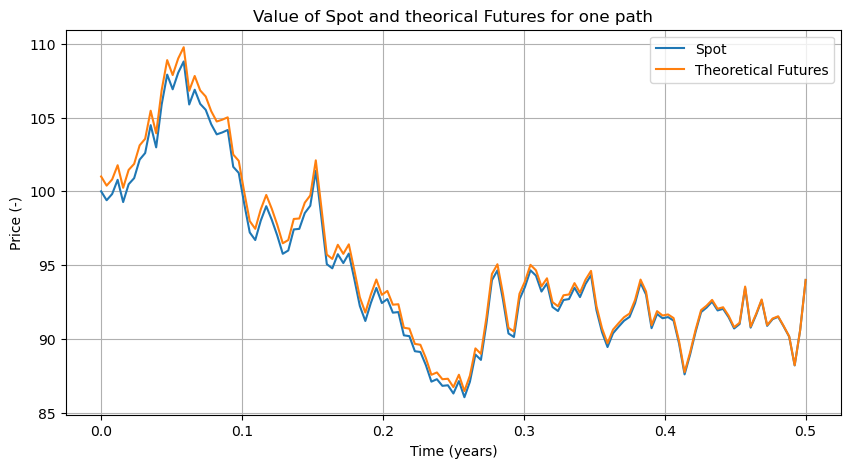

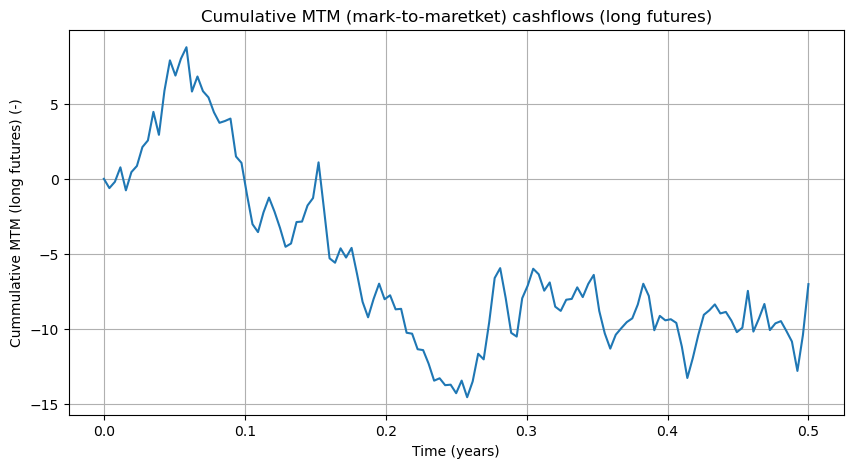

In [15]:
times, S_paths = simulate_gbm(S0, mu, sigma, T, n_steps, n_paths, seed=seed)

F0 = th_futures_price(S0, T, r, q)
print(f'Theorical futures price F0 = {F0:.6f}')

F_paths, mtm_cashflows, pv_mtm = compute_mtm_pv_from_spot_paths(S_paths, times, T, r, q)

#Forward payoff at maturity calculation (long forward price locked at F0)
S_T = S_paths[:, -1]
forward_payoff = S_T - F0        #payoff at maturity, not discounted
pv_forward = forward_payoff*np.exp(-r*T)

#Compare PV(MTM) and PV(Forward Payoff)
#They should be equal because r is deterministic 
diffs = pv_mtm - pv_forward

print(f'PV(MTM) - PV(Forward): mean = {diffs.mean()}, std = {diffs.std()}')

#Hedging demo : hedge one unit of spot by buying h unit short futures contract
#We show variance reduction
h = 0.5
unhedged_pnl = S_T - S0
short_futures_pnl = -h*mtm_cashflows.sum(axis=1)  #the '-' is here because we're short
hedged_pnl = unhedged_pnl + short_futures_pnl

#we therefore compute the variance
var_unhedged = np.var(unhedged_pnl)
var_hedged = np.var(hedged_pnl)

#and finally printing the results
print(f'Variance unhedged: {var_unhedged:6f}')
print(f'Variance hedge: {var_hedged:6f}')
print(f'Variance reduction: {1 - var_hedged/var_unhedged:.2%}')

#Plotting first path to visualize the relation
idx = 0
plt.figure(figsize=(10, 5)) #classic matplotlib plot method, cf. other projects
plt.plot(times, S_paths[idx], label=f'Spot')
plt.plot(times, F_paths[idx], label=f'Theoretical Futures')
plt.xlabel(f'Time (years)')
plt.ylabel(f'Price (-)')
plt.title(f'Value of Spot and theorical Futures for one path')
plt.legend()
plt.grid()
plt.show()

#Plotting cummulative MTM cashflows for the same path
cum_mtm = np.concatenate([[0], np.cumsum(mtm_cashflows[idx])])
plt.figure(figsize=(10, 5))
plt.plot(times, cum_mtm)
plt.xlabel(f'Time (years)')
plt.ylabel(f'Cummulative MTM (long futures) (-)')
plt.title('Cumulative MTM (mark-to-maretket) cashflows (long futures)')
plt.grid()
plt.show()